# Task and Data Analysis

In the task assigned to me, I faced various challenges due to the limitations of the data provided. The issues primarily stemmed from inconsistencies in tagging conventions and poorly labeled data. This hindered the evaluation process as accurately assessing and interpreting the data, leading to some inaccuracies and inefficiencies in the results derived from the analysis.

Key limitations of the data included:

- **Inconsistent Naming Conventions**: The tags varied significantly, making it difficult to evaluate consistently. For example, tags like “Zoom” and “Zoom mode,” “dvd player” and “player,” and “Universal remote control” and “remote” indicate a lack of standardisation.

- **Poor Labeling**: Some items were incorrectly labeled, such as labeling a “camera” to have a “door” feature. These inaccuracies questioned the reliability of the labels as a source of truth.

- **Raw Text Format**: The data required manual parsing, which is more error-prone compared to structured formats that could be easily read by built-in parsers, like CSV.

- **Complexity Added by Titles**: The inclusion of titles along with the body text in some reviews added an extra layer of complexity to the data parsing process.

- **Varying File Lengths**: Files varied in length. I tended to prefer larger files for their more substantial data volume, which I believed would provide a more robust basis for prediction.

To handle these issues, I developed a pipeline controlled by my `opinion_miner_controller` function. This pipeline is executed in the final two cells of my notebook, where the opinion miner runs and outputs various samples. The process includes several critical functions:

1. `read_file`: My data parser manages data nuances, such as titles, annotations, and special string characters. It separates text data from tags and sentiments, organising it into a structured Pandas dataframe.

2. `pre_processing_controller`: This function prepares the data for analysis by cleaning text, processing stop words, tokenising, lemmatising, and chunking nouns. Feature normalisation for machine learning is a part of pre-processing, but run outside of the main pipeline.

3. `feature_extraction`: Extracts features from the parsed review based on the pre-processing string type, a similarity threshold between product and features, and a choice between two feature extraction models. gloVe and Word2Vec similarity models are used to assst in extracting nouns with a relation to the product. 

5. `sentiment_controller`: Uses parameters like the sentiment classifier and the pre-processing review string type to apply a Vader or Senti classification or a SentiWordNet classification.

6. **Further Processing**: Includes creating feature table dictionaries and mapping dictionaries to align similar words (e.g., 'picture' and 'pic') to their correct tags for evaluation.

7. **Output**: Outputs include a confusion matrix, a metrics table showing precision, accuracy, recall, and the F1 score, and a feature table from the miner.

Additionally, outside the `opinion_miner_controller` function, I developed functions to optimise the miner’s performance:

- `average_metrics`: Averages evaluation metrics across three sample files.

- `sentiment_model_average_comparison`: Compares the performance of two sentiment models.

- `noun_model_comparison`: Shows differences between two noun extraction methods.

- `show_optimum_string_variables`: Identifies the best pre-processed strings for the miner.

- `sim_filter`: Finds the optimal similarity parameter for feature extraction.

- `build_ml_classifier` and `evaluate_ml_classifier`: An alternative approach using a OneVsRestClassifier to both extract and classify features. 

In [8]:
import pandas as pd
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import re
import copy

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load('en_core_web_lg') 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
Word2Vec_corpus = api.load('text8') 
Word2Vec_model = Word2Vec(Word2Vec_corpus) 
glove_model = api.load("glove-twitter-25") 
sentiment_intensity_analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /Users/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
files = ['Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt',
         'Data/Customer_review_data/Canon G3.txt',
         'Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
         'Data/Customer_review_data/Nikon coolpix 4300.txt',
         'Data/Customer_review_data/Nokia 6610.txt',
         'Data/CustomerReviews-3_domains/Computer.txt',
         'Data/CustomerReviews-3_domains/Router.txt',
         'Data/CustomerReviews-3_domains/Speaker.txt',
         'Data/Reviews-9-products/Canon PowerShot SD500.txt',
         'Data/Reviews-9-products/Canon S100.txt',
         'Data/Reviews-9-products/Diaper Champ.txt',
         'Data/Reviews-9-products/Hitachi router.txt',
         'Data/Reviews-9-products/ipod.txt',
         'Data/Reviews-9-products/Linksys Router.txt',
         'Data/Reviews-9-products/MicroMP3.txt',
         'Data/Reviews-9-products/Nokia 6600.txt',
         'Data/Reviews-9-products/norton.txt']

sample_file_list = [files[1], files[2], files[11]]

### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Data Pre-Processing

The data parsing process initiates with the `read_file` function, designed to effectively handle and extract pertinent content from data files. This function begins by reading the file, identifying, and excluding metadata indicated by a line of asterisks. It then addresses complexities such as titles marked by `[t]`, which are handled by the `handle_titles` function by appending the title to the corresponding review to preserve context and maintain data integrity.

Reviews are subsequently split using '##' as a delimiter to separate tags, which may contain embedded metadata and sentiment scores, from the main review content. The extracted tags and text data are then organised into a Pandas dataframe.

This dataframe is processed by the `pre_processing_controller`, which includes several key functions:
- **Tokenised_Review**: Tokenises reviews and preserves the integrity of compound phrases and adjectives directly linked to nouns using the `preserve_compound_phrases` function. This function constructs compound phrases by concatenating related words with an underscore, thus preserving semantic relationships within the text.
  
- **Soft_Filtered_Review**: Cleans up the Tokenised_Review by removing numerical characters, punctuation, and normalising capitalisation.
  
- **Soft_Filtered_Review_String**: Converts Soft_Filtered_Review to a string and processes it through `chunking_post_process` to further preserve compound phrases.
  
- **Filtered_Review**: Applies more aggressive filtering than Soft_Filtered_Review by removing stopwords, using the `nltk.corpus` library.
  
- **Lemmatised_Review_String**: Lemmatises reviews using the `Spacy` NLP library to reduce word dilution and enhance uniformity across the text data. Lemmatisation is a valuable pre-processing step that reduces words to their base forms, simplifying text complexity. Lemmatisation improves data consistency, by standardising words.


Additionally, the `parse_and_normalise_tags` function parses annotated tags into a machine-readable format and normalises features to create a vector matrix, facilitating further machine learning applications. 

#### References
- https://spacy.io/models/en/

In [10]:
def read_file(file_path):
    
    tagged_reviews = []
    
    with open(file_path, 'r') as file:
        text = file.read()
        # Split the text into lines and remove any leading/trailing whitespace
        reviews = text.strip().split('\n')

        # Check if the file starts with a specific marker line of asterisks
        if reviews[0] == '*' * 77:
            # Skip the first 11 lines if the marker is present - This is a quirk to parse the data files
            reviews = reviews[11:]

        reviews = hanldle_titles(reviews)
        
        for review in reviews:
            # Split each review on '##' to separate tags from the content
            parts = review.split('##')
            
            # If the split results in more than one part, process tags and content
            if len(parts) > 1:
                tags = parts[0].strip().split(',')
                content = parts[1].strip() 
            else:
                # If no '##' is found, set tags as empty and set content to the whole line
                tags = []
                content = parts
                
            # Append a dictionary of tags and review content to the list
            tagged_reviews.append({'Tags': tags, 'Review': content})

        df = pd.DataFrame(tagged_reviews)
        # Store the name of the file as an attribute of the DataFrame
        df.attrs['title'] = file_path.split('/')[-1]

        return df


def hanldle_titles(reviews):
    processed_reviews = []
    title_switch = False  # Indicates whether next review should append a title
    title = ''

    for review in reviews:
        if review.startswith('[t]'):  # Checks for title marker
            title = review[3:]  # Stores the title
            title_switch = True
        elif title_switch:  # Appends title to the review if flag is true
            processed_reviews.append(review + title)
            title_switch = False
            title = ''
        else:
            processed_reviews.append(review)  # Adds review as is if no title is pending

    return processed_reviews


In [11]:
def parse_and_normalise_tags(df):
    
    normalised_data = []

    for idx, tags in enumerate(df['Tags']):
        parsed_tags = {}
        parsed_sents = []

        for tag in tags:
            tag = tag.strip()
            inside = tag.find('[')
            outside = tag.find(']')
            feature = tag[0:inside].strip()
            sent = tag[inside + 1:outside].strip()
            
            try:
                sent = int(sent)
                if feature in parsed_tags:
                    # Average or list sentiment scores if more than one sentiment per feature
                    if isinstance(parsed_tags[feature], list):
                        parsed_tags[feature].append(sent)
                    else:
                        parsed_tags[feature] = [parsed_tags[feature], sent]
                else:
                    parsed_tags[feature] = sent
            except ValueError:
                continue  # Skip if the sentiment is not an integer

        # Normalise sentiments if there are multiple entries
        for key, value in parsed_tags.items():
            if isinstance(value, list):
                parsed_tags[key] = sum(value) / len(value)  # Average sentiments

        normalised_data.append(parsed_tags)

    # Add the normalised data to the DataFrame
    df['Normalised'] = normalised_data
    df = df[['Normalised', 'Lemmatised_Review_String']]
    df = df.rename(columns={'Normalised': 'Tags_and_Sentiment', 'Lemmatised_Review_String': 'Reviews'})

    # Flatten the normalised dictionary into a DataFrame
    tags_sents_df = pd.DataFrame(df['Tags_and_Sentiment'].tolist()).fillna(0).astype(int)

    # Join this back with the original DataFrame
    df = df.join(tags_sents_df)
    
    return df

In [12]:
def preserve_compound_phrases(text):
    # Process the text with an NLP model
    doc = nlp(text)
    processed_tokens = []

    for token in doc:
        # Check for compounds or adjectives linked directly to nouns
        if token.dep_ in ('compound', 'amod') and token.head.pos_ == 'NOUN':
            compound_phrase = f"{token.text}_{token.head.text}"
            if compound_phrase not in processed_tokens:
                processed_tokens.append(compound_phrase)
        # Skip nouns that are already part of a compound to prevent duplicates
        elif token.pos_ == 'NOUN' and any(child.dep_ == 'compound' for child in token.children):
            continue
        # Include all other tokens normally
        else:
            processed_tokens.append(token.text)

    return processed_tokens



def chunking_post_process(text):
    # Split the text into individual words
    words = text.split()
    processed_words = []

    i = 0
    while i < len(words):
        # Check if the current word is part of a compound phrase
        
        if '_' in words[i]:
            # Append all parts of the compound phrase to the list
            while i < len(words) and '_' in words[i]:
                processed_words.append(words[i])
                i += 1
            continue  # Move to the next word after finishing the compound phrase
        # Append non-compound words directly to the list
        processed_words.append(words[i])
        i += 1

    # Return the processed words as a single string
    return ' '.join(processed_words)

In [13]:
def pre_processing_controller(df):
    
    # Convert lists to strings and applies compound phrase preservation
    df['Tokenised_Review'] = df['Review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    df['Tokenised_Review'] = df['Tokenised_Review'].apply(lambda review: preserve_compound_phrases(review))
    
    # Filters the reviews. Handling compound phrases, capitalisation and numbers 
    df['Soft_Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower())])
    
    # Convert lists of tokens back to strings and retains the compound phrases - soft means not to filter out stop words
    df['Soft_Filtered_Review_String'] = df['Soft_Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
    df['Soft_Filtered_Review_String'] = df['Soft_Filtered_Review_String'].apply(chunking_post_process)
    
    # Filters the reviews. Handling compound phrases, capitalisation, numbers and stop words 
    df['Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower() not in stop_words)])
    df['Filtered_Review_String'] = df['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
    
    # Lemmatise the filtered review strings
    df['Lemmatised_Review_String'] = df['Filtered_Review_String'].apply(lambda review_string: " ".join([token.lemma_ for token in nlp(review_string)]))
    df['Lemmatised_Review'] = df['Filtered_Review_String'].apply(lambda review: word_tokenize(review))
    
    return df

### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Product Feature Extraction

The `feature_extraction` function is the controller function. It is passed three parameters:

- The `noun_comparison_flag` switches between the two feature extraction models during evaluation.
- The `noun_string` selects which pre-processed review to use
- The `similarity_threshold` defines the threshold to filter out dissimilar words

`POS_Noun_Tagging` - To extract features from the reviews, I have incorporated Part-of-Speech (POS) tagging, a NLP technique where each word in a text is tagged with its grammatical role using the `pos_tag` function from the NLTK package. This tagging considers the word itself and also its context within the sentence. It factors the word's positioning relative to others and the overall sentence structure, which enhances the precision of the tagging process. The text then undergoes noun extraction, where words tagged with specific noun labels such as 'NN', 'NNS', 'NNP', 'NNPS' are retained. These nouns are then subjected to frequency analysis, identifying the 15 most common nouns for further analysis or processing. The 15 filter was manually chosen through analysing various compund noun outputs.

`dependency_parsing_noun_extraction` - I also developed a dependency parser as a more advanced feature extraction model, which surpasses traditional POS tagging by constructing a detailed dependency tree. This tree visually maps the relationships between words in a sentence, using arrows to denote dependencies and illustrate which words depend on others. This approach provides a comprehensive map of word interactions and strongly enhances semantic understanding. According to the Stanford CS224n course on dependency parsing, this technique excels in accurately identifying grammatical roles and relationships, making it particularly effective in clarifying complex constructions like passive voice and nested phrases. This clarity is crucial for accurately interpreting sentences and extracting meaningful information, which aids in tasks like sentiment analysis and information extraction. Dependency parsing also plays a critical role in Semantic Role Labeling by assigning semantic roles to phrases based on their function in the main action of the sentence. Its linguistic consistency across different languages also strengthens its value.

`similarity_filter` - This function is designed to refine a list of nouns, presumed to be features of a particular product, ensuring that only the most relevant and distinct nouns are retained. Initially, the product is identified as the first noun in the list, given that the list is sorted by noun relevance. The function then extracts words from a list of tuples, discarding any secondary values. It calculates the semantic similarity of each word to the product using both Word2Vec and GloVe models, and an average of these similarities determines the relevance of each noun. Words that meet a predefined similarity threshold are retained for further consideration. To enhance the uniqueness of the selected features, the function applies a secondary filtering process. This process removes synonyms or near synonymous words such as 'pic' and 'picture', by examining the similarity scores from GloVe's top similar words and excluding those that are highly similar. The models averaging adds a level of diversification. The 15 most common nouns are selected also.

#### References
- https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00561-y
- https://towardsdatascience.com/natural-language-processing-dependency-parsing-cf094bbbe3f7
- https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes04-dependencyparsing.pdf

In [14]:
def feature_extraction(df, noun_string, similarity_threshold, noun_comparison_flag):

    if noun_comparison_flag == 1:
        nouns = POS_Noun_Tagging(df, noun_string)
    else:
        nouns = dependency_parsing_noun_extraction(df, noun_string)

    features = similarity_filter(nouns, similarity_threshold)
    df = add_features_to_df(df, features)
    
    return df, features

In [15]:
def POS_Noun_Tagging(df, noun_string):
    # Convert the string list to a regular list
    reviews = df[noun_string].tolist()
    features = []
    
    # Process each review to extract nouns
    for review in reviews:
        tokens = word_tokenize(review)  # Tokenise the text
        tagged = pos_tag(tokens)  # POS tagging
        # Collect nouns from tags
        features.extend([word.lower() for word, tag in tagged if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
    
    # Count and retrieve the 15 most common nouns
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(15)

    return common_features

In [16]:
def dependency_parsing_noun_extraction(df, noun_string):
    # Convert the string list to a regular list
    reviews = df[noun_string].tolist()
    features = []

    # Process each review to extract nouns using dependency parsing
    for review in reviews:
        doc = nlp(review)
        # Extract nouns based on their dependency role and POS tag
        features.extend([token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']])

    # Count and retrieve the most common nouns
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(15)
    
    return common_features

In [17]:
def similarity_filter(word_tuple_list, similarity_threshold):
    
    # Create a list of words from the tuples
    words = [word for word, _ in word_tuple_list]
    
    noun_list = []
    # Iterate over words to compute similarities
    for word in words:
        try:
            # Calculate similarity using Word2Vec
            w2v_similarity = Word2Vec_model.wv.similarity(words[0], word)
            # Calculate similarity using GloVe
            glove_similarity = glove_model.similarity(words[0], word)
            
            # Calculate average similarity
            avg_similarity = (w2v_similarity + glove_similarity) / 2
            
            # Append word to list if it meets the threshold
            if avg_similarity >= similarity_threshold:
                noun_list.append(word)
        except KeyError:
            # Skip the word if it's not found in the model's vocabulary
            continue

    items_to_remove = []
    
    for word in noun_list:
        glove_similar_words = dict(glove_model.most_similar(noun_list[0], topn=10))
        glove_similarity = glove_similar_words.get(word, 0) 
        if glove_similarity > 0:
            items_to_remove.append(word)
    
    filtered_nouns = [item for item in noun_list if item not in items_to_remove]

    return filtered_nouns

In [18]:
"""
These functions are utilised within the opinion_miner_controller module.
The primary function, create_feature_table, takes a DataFrame and a list of features as input.
It processes the DataFrame, extracting features and sentiments, then updates a dictionary with the feature counts.
Each review's features and sentiments are converted into tags, following a specific format for labeling data.
These tags are added to the main DataFrame under the column 'My_Sentiment_Tags' for later evaluation.
"""


def add_features_to_df(df, features):
    
    feature_list = features[1:]
    featured_items_list = []
    index_list = []
    
    for idx, review in df.iterrows():
        tokenised_review = review['Filtered_Review']
        # Find the features present in the tokenised_review
        featured_items = [item for item in feature_list if item in tokenised_review]
            
        if featured_items:
            # Append the found features as a string 
            featured_items = [item for item in feature_list if item in tokenised_review]
            item_list = [f"{item.strip()}" for item in featured_items]
            featured_items_string = ', '.join(item_list)
            featured_items_list.append(featured_items_string) 
            index_list.append(idx)
        else:
            featured_items_list.append('')  
            index_list.append(idx)

    df['Main_Index'] = index_list
    df['Featured_Items'] = featured_items_list
    
    return df


def create_feature_table(df, features):
    # Process the DataFrame
    df = process_data_df(df)
    
    # Extract the product title and features
    product_title = features[0]
    product_features = features[1:]
    
    # Create a dictionary to store feature counts
    product_dict = {product_title: {feature: {'positive': 0, 'negative': 0} for feature in product_features}}
    
    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Split the featured items and sentiments
        feature_items = row['Featured_Items'].split(',')
        sentiments = row['Sentiment'] if isinstance(row['Sentiment'], list) else [row['Sentiment']]
        
        # Update the feature table with counts
        for feature, sentiment in zip(feature_items, sentiments):
            update_feature_table(product_dict, product_title, feature.strip(), sentiment)
    
    return product_dict, df



def update_feature_table(product_dict, title, feature, sentiment):
    # Update the feature counts based on sentiment
    if feature and feature in product_dict[title]:
        if sentiment > 0:
            product_dict[title][feature]['positive'] += 1
        elif sentiment < 0:
            product_dict[title][feature]['negative'] += 1



def process_data_df(df):
    my_tags = []
    
    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Split features and get sentiments
        features = row['Featured_Items'].split(',') if row['Featured_Items'] else []
        sentiments = row['Sentiment']
        
        # Process features and sentiments into tags
        tags = process_features_and_sentiments(features, sentiments)
        my_tags.append(tags)
    
    # Add tags to the DataFrame
    df['My_Sentiment_Tags'] = my_tags
    
    return df



def process_features_and_sentiments(features, sentiments):
    result_tags = []  # This will store the final list of sentiment tags for the features

    # Ensure sentiments is always a list
    if not isinstance(sentiments, list):
        sentiments = [sentiments]  # Convert single integer to list

    # Loop through each feature and its index
    for i, feature in enumerate(features):
        # Strip any whitespace around the feature name to ensure clean data
        cleaned_feature = feature.strip()

        # Continue only if the feature is not an empty string
        if cleaned_feature:
            # Access the corresponding sentiment value or default to 0 if out of range
            sentiment_value = sentiments[i] if i < len(sentiments) else 0

            # Format the feature and its sentiment into a string, appending it to the result list
            tag_string = f"{cleaned_feature}[{sentiment_value}]"
            result_tags.append(tag_string)

    return result_tags


### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Sentiment Analysis

The `sentiment_controller` function inputs the data dataframe, the classifier and the string type to in which to formulate the sentiment. 
Each feature that has been labelled will be passed individual for sentiment classification, for each review in the file.

I have selected two models for sentiment analysis, `SentiWordNet` and `VADER`, each with distinct strengths and applications.

#### SentiWordNet
SentiWordNet is an advanced lexical resource that augments the traditional WordNet database by integrating three types of sentiment scores: positivity, negativity, and objectivity, into each synset. These sentiment scores, ranging from 0 to 1, describe how objective, positive, and negative the terms within the synset are, determined through semi-supervised learning techniques and manual adjustments to ensure an accurate reflection of word sentiments. SentiWordNet enhances text representations by adding sentiment related properties of terms. The development of SentiWordNet involves the quantitative analysis of glosses related to synsets and vectorial term representations. This process uses a committee of eight classifiers with similar accuracy levels but differing behaviours to derive the sentiment scores, thereby providing detailed word sense representation and extensive coverage of over 115,000 WordNet synsets. However, SentiWordNet has limitations, including static sentiment scores that may not reflect changing contextual meanings, limited coverage of modern slang or newly coined terms, and potential inaccuracies in capturing the sentiments of polysemous words due to its reliance on generalised word usage.

#### VADER
To address some of the limitations seen in SentiWordNet, particularly in handling dynamic and informal text, VADER (Valence Aware Dictionary and sEntiment Reasoner) presents it self as a strong alternative. Recognised for its ability to efficiently process and analyse large volumes of text data, VADER is particularly valuable for evaluating customer feedback on social media, which may well translate to online produt reviews. Its strength lies in managing texts that feature unconventional forms, such as emojis, varied punctuation, and internet specific expressions. The core of VADER's functionality is its sentiment lexicon, developed through crowdsourced input via Amazon’s Mechanical Turk. This approach ensures the lexicon is not only comprehensive but also reflective of modern language and expressions typical in social media communications. Unlike SentiWordNet, VADER is stronger when understanding context, assessing how sentiments are influenced by how something is said through capitalisation, punctuation, or other stylistic nuances rather than solely by what is said. This sophisticated context understanding makes VADER especially effective in sentiment analysis, providing a deep insight into both explicit and implicit sentiments embedded within digital communications.

#### References

- https://ontotext.fbk.eu/sentiwn.html
- https://srish6.medium.com/sentiment-analysis-using-the-sentiwordnet-lexicon-1a3d8d856a10
- https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/
- https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53
- https://vadersentiment.readthedocs.io/en/latest/
- https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/

In [19]:
def sentiment_controller(df, classifier, sent_string):

    sentiment_list = []
    
    # Function to get sentiment
    def get_sentiment(review, classifier, features):
        if classifier == 'senti':
            pos_score, neg_score = senti_classifier(review)
            return 1 if pos_score > neg_score else -1
        elif classifier == 'vader':
            return vader_classifier(review, features)
        return 0  # default case if no classifier matches

    # Process each review in the DF
    for idx, row in df.iterrows():
        review = row[sent_string]
        features = [feature.strip() for feature in row['Featured_Items'].split(',')]
        
        # Apply sentiment analysis for each feature or single feature case
        if len(features) == 1:  
            sentiment = get_sentiment(review, classifier, features)
            sentiment_list.append(sentiment)
        else: 
            sentiments = [get_sentiment(review, classifier, [feature]) for feature in features]
            sentiment_list.append(sentiments)
            
    df['Sentiment'] = sentiment_list
    
    return df

In [20]:
def senti_classifier(phrase):
    
    # First try to get sentiment score for the whole phrase as a compound
    pos_score, neg_score = get_word_sentiment(phrase.replace(" ", "_"))
    if pos_score or neg_score:
        return pos_score, neg_score
    
    # If no score, break down the phrase and calculate average sentiment scores
    words = phrase.split()
    total_pos, total_neg = 0, 0
    for word in words:
        pos, neg = get_word_sentiment(word)
        total_pos += pos
        total_neg += neg
    
    # Average the sentiment scores
    avg_pos = total_pos / len(words) if words else 0
    avg_neg = total_neg / len(words) if words else 0
    
    return avg_pos, avg_neg


def get_word_sentiment(word):
    # Retrieve sentiment scores from SentiWordNet
    synsets = list(swn.senti_synsets(word))
    if synsets:
        return synsets[0].pos_score(), synsets[0].neg_score()
    else:
        return 0, 0

In [21]:
def vader_classifier(sentence, features):
    
    # Dictionary to store sentiment results for each feature
    sentiment_results = {}

    features = [feature.strip() for feature in features]  
    
    # Analyse sentiment for each feature
    for feature in features:
        # Extract context around the feature if needed (optional improvement)
        start_index = sentence.lower().find(feature.lower())
        if start_index != -1:
            # Extract a sub-sentence for context-based sentiment analysis
            sub_sentence = sentence[max(start_index - 30, 0):min(start_index + 30 + len(feature), len(sentence))]

            # Get sentiment using VADER
            vader_sentiment = sentiment_intensity_analyser.polarity_scores(sub_sentence)['compound']
  
            sentiment = 1 if vader_sentiment > 0.05 else -1 if vader_sentiment < -0.05 else 0
            
        else:
           sentiment = 0
            
    return sentiment

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight



def build_ml_classifier(df):
    
    def extract_features(tags_sentiments_dict):
        return [f"{tag}_{sentiment}" for tag, sentiment in tags_sentiments_dict.items()]
    
    df['Feature_Sentiments'] = df['Tags_and_Sentiment'].apply(extract_features)
    
    # Now apply MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(df['Feature_Sentiments'])
    
    vectorizer = TfidfVectorizer(max_features=1000)
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    for train_index, test_index in msss.split(df['Reviews'], Y):
        X_train = vectorizer.fit_transform(df.loc[train_index, 'Reviews'])
        Y_train = Y[train_index]
        X_test = vectorizer.transform(df.loc[test_index, 'Reviews'])
        Y_test = Y[test_index]
    
        # Calculate class weights for balancing
        class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.ravel())
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
        
        model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
        model.fit(X_train, Y_train)
    
        # Accessing reviews during prediction (for illustration or further analysis)
        predictions = []
        for idx in test_index:
            review = df.loc[idx, 'Reviews']
            new_review_processed = vectorizer.transform([review])
            predicted = model.predict(new_review_processed)
            predicted_labels = mlb.inverse_transform(predicted)
            predictions.append(predicted_labels)
    
    labels = list(df['Tags_and_Sentiment'].iloc[1372:])
    
    return predictions, labels


### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Evaluation


In [23]:
"""
Processing functions to:
    - Filter for the models sentiment tags and the data's sentiment tags
    - Extracts the data's sentiment tags as a dictionary 
    - Creates a mapping dictionary that maps the models features with the datas features, with similarity variability
    - Create a dataframe for the models labeled reviews and the datas labeled reveiws for evaluation 
"""



def create_evaluation_table(df):
    
    valid_rows = []

    # Iterate through each row and check if 'Tags' is non-empty
    for idx, row in df.iterrows():
        # Check if the first element in 'Tags' is not an empty string
        try:
            if row['Tags'][0] != '':
                # Append the row (as a DataFrame) to the list
                valid_rows.append(row)
        except:
            pass

    eval_df = pd.DataFrame(valid_rows)
    
    return eval_df[['Tags', 'My_Sentiment_Tags']]




def extract_tags(sentiment_string):
    
    # Ensure the input is a string for regex operations
    if not isinstance(sentiment_string, str):
        if isinstance(sentiment_string, list):
            # If it's a list, convert to a comma-separated string
            sentiment_string = ', '.join(sentiment_string)
        else:
            # Otherwise, convert to string in any other case
            sentiment_string = str(sentiment_string)
    
    # Use regex to find patterns of words followed by [number] and convert to a dictionary
    output = {match[0]: int(match[1]) for match in re.findall(r'(\w+)\[([+-]?\d+)\]', sentiment_string)}

    return output




def evaluation_mapping(evaluation_dict, key_mapping):

    # Create a dictionary with unique keys and initialise sentiment counts
    unique_keys = set(key_mapping.values())
    data_dict = {key.strip().lower(): {'positive': 0, 'negative': 0} for key in unique_keys if key}

    # Populate the dictionary with sentiment values from the evaluation_dict using the key_mapping
    for key, sentiments in evaluation_dict.items():
        mapped_key = key_mapping.get(key)
        if mapped_key:
            mapped_key = mapped_key.strip().lower()
            if mapped_key in data_dict:
                # Increment sentiment counts based on mapped keys
                data_dict[mapped_key]['positive'] += sentiments['positive']
                data_dict[mapped_key]['negative'] += sentiments['negative']
                
    return data_dict




def find_similar_features(my_features, annotated_features, threshold=0.7):

    similar_features = {}
    # Convert feature lists to spaCy NLP objects for vector comparison
    annotated_features_nlp = {feature: nlp(feature) for feature in annotated_features}
    my_features_nlp = {feature: nlp(feature) for feature in my_features}

    # Compare each feature's NLP object for similarity above a set threshold
    for my_feat, my_feat_nlp in my_features_nlp.items():
        for anno_feat, anno_feat_nlp in annotated_features_nlp.items():
            # Check if both terms have vectors and compare their similarity
            if my_feat_nlp.has_vector and anno_feat_nlp.has_vector:
                if my_feat_nlp.similarity(anno_feat_nlp) > threshold:
                    similar_features[my_feat] = anno_feat
    
    return similar_features

    


def process_tags(df, key_mapping):

    results = []
    reverse_mapping = {v: k for k, v in key_mapping.items()}

    # Iterate through DataFrame to apply mappings and extract sentiments
    for idx, row in df.iterrows():
        tags = extract_tags(row['Tags'])
        my_sentiment_tags = extract_tags(row['My_Sentiment_Tags'])

        # Compare and store results of tag sentiments
        for tag, sentiment in tags.items():
            mapped_tag = reverse_mapping.get(tag, tag)  # Map tags to a common key, if possible
            if mapped_tag in my_sentiment_tags:
                # Store results if there's a matching sentiment tag
                results.append({
                    'Index': idx,
                    'Feature': mapped_tag,
                    'Tags Sentiment': sentiment,
                    'My Sentiment Tags Sentiment': my_sentiment_tags[mapped_tag]
                })

    return pd.DataFrame(results)

In [24]:
"""
Processing functions to create the confusion matrix, calculate the metrics from the matrix and output a matrix comparison chart
"""



def compute_confusion_matrix(result_df):

    # Initialise counters for True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
    TP = FP = TN = FN = 0

    # Iterate through each row in the DataFrame to compare sentiment tags
    for index, row in result_df.iterrows():
        
        # Extract sentiment from 'Tags Sentiment' and 'My Sentiment Tags Sentiment'
        tag_sent = row['Tags Sentiment']
        my_sent = row['My Sentiment Tags Sentiment']

        # Compare extracted sentiments and classify as TP, FP, TN, or FN
        if tag_sent > 0 and my_sent > 0:
            TP += 1
        elif tag_sent <= 0 and my_sent > 0:
            FP += 1
        elif tag_sent <= 0 and my_sent <= 0:
            TN += 1
        elif tag_sent > 0 and my_sent <= 0:
            FN += 1

    # Sum up all counts and create a DataFrame for the confusion matrix
    df = pd.DataFrame({'Total': (TP + FP + TN + FN),
                       'TP': [TP],
                       'FP': [FP],
                       'TN': [TN],
                       'FN': [FN]}, index=['Overall'])
    
    return df




def calculate_metrics(conf_matrix):

    # Extract confusion matrix values
    TP = conf_matrix.loc['Overall', 'TP']
    FP = conf_matrix.loc['Overall', 'FP']
    TN = conf_matrix.loc['Overall', 'TN']
    FN = conf_matrix.loc['Overall', 'FN']
    
    # Calculate precision, recall, accuracy, and F1 score using the extracted values
    precision = TP / (TP + FP) if TP + FP != 0 else 0  # Avoid division by zero
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    # Create a DataFrame to hold calculated metrics, rounded to three decimals
    df = pd.DataFrame({'Precision': [round(precision, 3)], 
                       'Recall': [round(recall, 3)],
                       'Accuracy': [round(accuracy, 3)],
                       'F1 Score': [round(f1_score, 3)]}, index=['Overall'])
    
    return df




def plot_comparison_metrics(avg_metrics_1, avg_metrics_2, option):

    # Define metric labels
    labels = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
    
    # Adjust data scales to exaggerate differences for clearer visual comparison
    diff_scale = 10
    adjusted_data1 = [1 + (val - min(avg_metrics_1 + avg_metrics_2)) * diff_scale for val in avg_metrics_1]
    adjusted_data2 = [1 + (val - min(avg_metrics_1 + avg_metrics_2)) * diff_scale for val in avg_metrics_2]
    
    # Define bar width
    bar_width = 0.35
    
    # Initialise plot
    fig, ax = plt.subplots()
    index = np.arange(len(labels))
    
    # Plot data for both metric sets
    if option == 'sent':
        bars1 = ax.bar(index - bar_width/2, adjusted_data1, bar_width, label='Vader')
        bars2 = ax.bar(index + bar_width/2, adjusted_data2, bar_width, label='Senti')
        name = 'Sentiment Models'
    else:
        bars1 = ax.bar(index - bar_width/2, adjusted_data1, bar_width, label='POS')
        bars2 = ax.bar(index + bar_width/2, adjusted_data2, bar_width, label='Dependency')
        name = 'Noun Extraction Models'
    
    # Set labels, title, and legend for the plot
    ax.set_xlabel('Metric')
    ax.set_ylabel('Adjusted Score')
    ax.set_title(f'Comparison of {name} with Exaggerated Differences')
    ax.set_xticks(index)
    ax.set_xticklabels(labels)
    ax.legend()
    
    # Display the plot
    plt.show()


In [25]:
"""
Main controller function of the Opinion Miner

Arguments: 
    - File: The file name to be parsed
    - sentiment_classifier: A string to define which sentiment classifer should be selected 
    - noun_string: Parameter to select which pre-processed review type to use for feature extraction
    - sent_string: Parameter to select which pre-processed review type to use for sentiment analysis
    - similarity_threshold: Parameter used during feature extraction to define how close the feautre list should be to the predicted name of the product

Returns:
    - conf_matrix_df: A confusion matrix comparing my models feature classifications with the provided data set
    - metrics_df: A table displaying the precision, recall, accuracy and F1 Score
"""



def opinion_miner_controller(file, sentiment_classifier, noun_string, sent_string, similarity_threshold, noun_comparison_flag):

    # Parse the raw text file into a pandas dataframe
    df = read_file(file)

    # Handle the reviews in various ways and store each variation in a master dataframe for further analysis 
    df = pre_processing_controller(df)

    # Extracts a list of product features from the reviews, add data to the master dataframe
    df, features = feature_extraction(df, noun_string, similarity_threshold, noun_comparison_flag)

    # Calculates the sentiment of each feature in each review, passing in two sentiment parameters and returning an updated master dataframe
    df = sentiment_controller(df, sentiment_classifier, sent_string)

    # Extracts a feature table and updates the master dataframe with sentiment labeled 
    feature_table, df = create_feature_table(df, features)

    # Filters the master dataframe for the models sentiment tags and the data's sentiment tags
    evaluation_table = create_evaluation_table(df)
    
    # Extracts the data's sentiment tags and returns a dictionary 
    annotated_tags_dict = extract_tags(evaluation_table)
    
    # Creates a dictionary that maps the models features with the datas features, allowing some variation in similarity
    key_mapping = find_similar_features(annotated_tags_dict.keys(), feature_table[next(iter(feature_table))].keys())

    # Outputs a dataframe with the models labeled reviews and the datas labeled reveiws for evaluation
    result_df = process_tags(evaluation_table, key_mapping)    
    
    # Calculates a confusion matrix and metrics table 
    conf_matrix_df = compute_confusion_matrix(result_df)
    metrics_df = calculate_metrics(conf_matrix_df)
    
    return feature_table, conf_matrix_df, metrics_df, df
    

In [26]:
"""
A function built to average the metrics across files to assist myself in paramater selection due to the large variability in the data files
The sentiment_model_average_comparison function is used to show the metric comparison between my two sentiment models, averaged across the three sample files.
"""


def average_metrics(file_list, sentiment_classifier, noun_string, sent_string, similarity_threshold, noun_comparison_flag):
    
    data = {}
    file_idx = 0
    
    for file in file_list:
        file_idx += 1
        feature_table, conf_matrix, metrics, _ = opinion_miner_controller(file, sentiment_classifier, noun_string, sent_string, similarity_threshold, noun_comparison_flag)
        data[file_idx] = {'conf_matrix': conf_matrix, 'metrics': metrics}
    
    count = 0
    precision, recall, accuracy, f1_score = 0, 0, 0, 0
    
    for entry in data:
        count += 1
        precision += data[entry]['metrics']['Precision'].iloc[0]
        recall += data[entry]['metrics']['Recall'].iloc[0]
        accuracy += data[entry]['metrics']['Accuracy'].iloc[0]
        f1_score += data[entry]['metrics']['F1 Score'].iloc[0]
    
    avg_precision = round(precision / count, 3)
    avg_recall = round(recall / count, 3)
    avg_accuracy = round(accuracy / count, 3)
    avg_f1_score = round(f1_score / count, 3)
    
    return avg_precision, avg_recall, avg_accuracy, avg_f1_score



def sentiment_model_average_comparison(file_list):

    print('\n')
    avg_vader_metrics = average_metrics(file_list, 'vader', 'Lemmatised_Review_String', 'Review', 0.25, 1)
    avg_senti_metrics = average_metrics(file_list, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)
    plot_comparison_metrics(avg_vader_metrics, avg_senti_metrics, 'sent')


def noun_model_comparison(file):
    
    print('\n')
    pos_metrics = average_metrics(file, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)
    dependency_metrics = average_metrics(file, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 0)
    plot_comparison_metrics(pos_metrics, dependency_metrics, 'nouns')

In [27]:
"""
The method I used to see which pre-processing review string combination to use when extracting features and classifying
"""


def show_optimium_string_variables(files):
    
    for noun_string in ['Soft_Filtered_Review_String', 'Lemmatised_Review_String']:
        for sent_string in ['Soft_Filtered_Review_String', 'Lemmatised_Review_String', 'Filtered_Review_String']:
    
            try:
                print('Noun String: ', noun_string, 'Sent String: ', sent_string)
                _, conf_matrix_df, metrics_df, _ = opinion_miner_controller(files[0], 'senti', noun_string, sent_string)
                display(conf_matrix_df)
                display(metrics_df)
            except:
                pass

# show_optimium_string_variables(files)

In [28]:
"""
The method I used to see which similarity filter to use in my noun feature processing 
"""


def sim_filter(files):
    
    for sim in np.arange(0, 0.5, 0.05).tolist():
        _, conf_matrix_df, metrics_df, _ = opinion_miner_controller(files[0], 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', sim, 1)
        display(conf_matrix_df)
        display(metrics_df)
        
# sim_filter(files)

In [29]:
def evaluate_ml_classifier(predictions, labels):

    TP, FP, TN, FN = 0, 0, 0, 0
    
    for prediction, label in zip(predictions, labels):
        
        for pred in prediction[0]:
            
            split_pred = pred.split('_')
            pred_feature = split_pred[0]
            pred_sent = int(split_pred[1])

            if pred_feature in label.keys():
                if pred_sent > 0 and label.get(pred_feature) > 0:
                    TP += 1
                elif pred_sent > 0 and label.get(pred_feature) < 0:
                    FP += 1
                elif pred_sent < 0 and label.get(pred_feature) < 0:
                    TN += 1
                elif pred_sent < 0 and label.get(pred_feature) > 0:
                    FN += 1
                else:
                    pass
                    
    # Sum up all counts and create a DataFrame for the confusion matrix
    conf_df = pd.DataFrame({'Total': (TP + FP + TN + FN),
                            'TP': [TP],
                            'FP': [FP],
                            'TN': [TN],
                            'FN': [FN]}, index=['Overall'])

    # Calculate precision, recall, accuracy, and F1 score using the extracted values
    precision = TP / (TP + FP) if TP + FP != 0 else 0  # Avoid division by zero
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    
    # Create a DataFrame to hold calculated metrics, rounded to three decimals
    metric_df = pd.DataFrame({'Precision': [round(precision, 3)], 
                              'Recall': [round(recall, 3)],
                              'Accuracy': [round(accuracy, 3)],
                              'F1 Score': [round(f1_score, 3)]}, index=['Overall'])
 
    display(conf_df)
    display(metric_df)

In [30]:
def show_examples(file_list):
    
    for file in file_list:
        feature_table, conf_matrix_df, metrics_df, _ = opinion_miner_controller(file, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)

        df = pd.DataFrame(feature_table[next(iter(feature_table))]).T
        df.index.name = next(iter(feature_table))
        df.columns = ['Positive Sentiments', 'Negative Sentiments']
        
        df.plot(kind='bar', figsize=(8, 3), title=f'Sentiment Analysis of {next(iter(feature_table))} Features')
        plt.xlabel(f'{next(iter(feature_table))} Feature')
        plt.ylabel('Number of Sentiments')
        plt.show()
        
        print('\n')
        display(conf_matrix_df)
        print('\n')
        display(metrics_df)
        print('-------------------------------------------------------------------------------------------')
        print('\n')


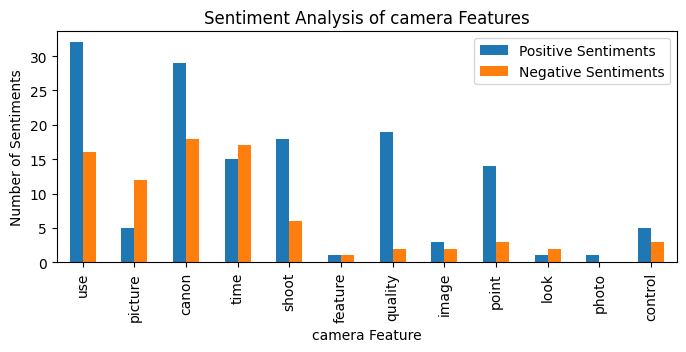

,Total,TP,FP,TN,FN
Overall,24,18,1,0,5


,Precision,Recall,Accuracy,F1 Score
Overall,0.947,0.783,0.75,0.857


-------------------------------------------------------------------------------------------




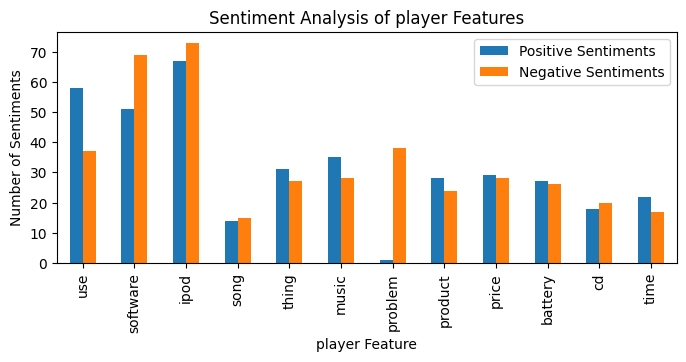

,Total,TP,FP,TN,FN
Overall,129,53,11,22,43


,Precision,Recall,Accuracy,F1 Score
Overall,0.828,0.552,0.581,0.662


-------------------------------------------------------------------------------------------




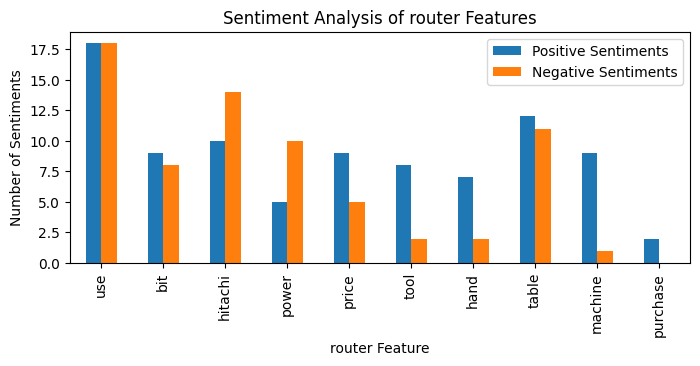

,Total,TP,FP,TN,FN
Overall,42,21,3,4,14


,Precision,Recall,Accuracy,F1 Score
Overall,0.875,0.6,0.595,0.712


-------------------------------------------------------------------------------------------






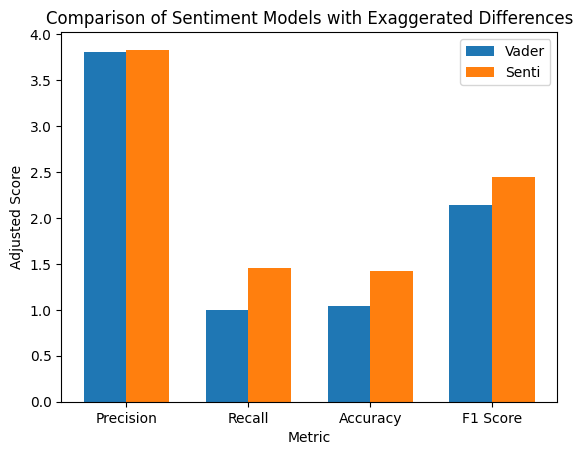

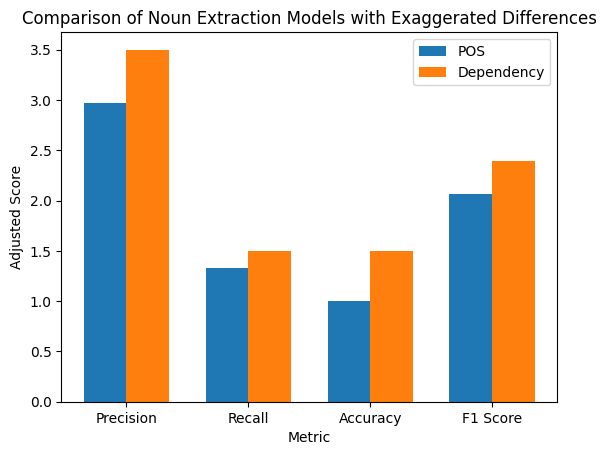

In [33]:
show_examples(sample_file_list)
sentiment_model_average_comparison(sample_file_list)
noun_model_comparison([files[1]])

In [32]:
feature_table, conf_matrix_df, metrics_df, df = opinion_miner_controller(files[2], 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)
df = parse_and_normalise_tags(copy.deepcopy(df))
predictions, labels = build_ml_classifier(df)
evaluate_ml_classifier(predictions, labels)

/Users/leon/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 317 is present in all training examples.
  warnings.warn(


,Total,TP,FP,TN,FN
Overall,7,3,4,0,0


,Precision,Recall,Accuracy,F1 Score
Overall,0.429,1.0,0.429,0.6
